# Stocks EDA, Cluster Analysis

## Team:
> SPaRrow

## Members:
1. Samer Baslan (SB)
2. Princy Joy (PJ)
3. Rohan Kumar (RK)


## Datasets:
1. Nasdaq
2. Yahoo! Finance

## Import Modules

In [ ]:
!pip install ta
!pip install yfinance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests as rq
import seaborn as sns
import warnings
import yfinance as yf
from bs4 import BeautifulSoup
from functools import reduce
from google.colab import drive
from IPython.display import clear_output
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from ta.volatility import BollingerBands
from time import time

%matplotlib inline
sns.set()
warnings.simplefilter(action="ignore", category=FutureWarning)

  Created wheel for ta: filename=ta-0.7.0-cp37-none-any.whl size=28716 sha256=1729d7ae5841a32db945082149453f54f7355c97731ce30f241e2e1ddf1ac28c
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta
     |████████████████████████████████| 5.5MB 6.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=e02baa8234b656f2795402aa257c40538df0579be3572df497f2ae92c25d2073
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Global Paramaters

In [ ]:
USE_YF = False
SAMPLE = 50000
FIG_SIZE = (15, 7)

## Global Functions

In [ ]:
def find_variance(x):
    x = StandardScaler().fit_transform(x)
    pca = PCA()
    pca.fit_transform(x)

    total = sum(pca.explained_variance_)
    variance = 0
    k = 0

    while variance / total < 0.90:
        variance += pca.explained_variance_[k]
        k += 1

    pca = PCA(n_components=k)
    data = pca.fit_transform(x)

    print(k, "dimensions needed for 90% variance")
    plt.bar(range(k), pca.explained_variance_ratio_.cumsum() * 100)

    columns = []
    for i in range(1, k + 1):
        columns.append("PC" + str(i))

    return pd.DataFrame(data, columns=columns)


def gini_score(x, y):
    x_train, _, y_train, _ = train_test_split(x, y, test_size=.2, random_state=1)
    classifier = RandomForestClassifier(criterion="gini").fit(x_train, y_train)
    feature_importance = pd.Series(classifier.feature_importances_, index=x.columns).sort_values(ascending=False)

    plt.subplots(figsize=FIG_SIZE)
    ax = sns.barplot(x=feature_importance, y=feature_importance.index)
    ax.set_yticklabels(feature_importance.index)
    ax.set_xlabel("Feature Importance")
    plt.show()


def muller_loop_classifiers(x, y):
    classifiers = [
        ("Nearest Neighbors", KNeighborsClassifier(2)),
        ("Linear SVM", SVC(kernel="linear", C=0.025)),
        ("RBF SVM", SVC(gamma=2, C=1)),
        ("Decision Tree", DecisionTreeClassifier(max_depth=5)),
        ("Random Forest", RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)),
        ("Neural Net", MLPClassifier(alpha=1, max_iter=1000)),
        ("AdaBoost", AdaBoostClassifier()),
        ("Naive Bayes", GaussianNB()),
        ("QDA", QuadraticDiscriminantAnalysis())
    ]

    x = StandardScaler().fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

    max_class = None
    max_score = 0.0
    max_index = None
    plot_x = []
    plot_y = []
    index = 0

    for name, classifier in classifiers:
        start_time = time()
        classifier.fit(x_train, y_train)
        score = classifier.score(x_test, y_test) * 100
        print("Classifier = %s, Score = %.2f, Training Time = %.2f" % (
            name, score, time() - start_time))
        if score > max_score:
            max_class = name
            max_score = score
            max_index = index
        plot_x.append(name)
        plot_y.append(score)
        index += 1

    print(100 * "-")
    print("Best --> Classifier = %s, Score = %.2f" % (max_class, max_score))

    plt.bar(plot_x, plot_y)[max_index].set_color("g")
    plt.xticks(rotation=75)
    plt.show()


def muller_loop_regression(x, y):
    regressors = [
        ("KNearest Neighbors", KNeighborsRegressor(n_neighbors=2)),
        ("Linear Regression", LinearRegression()),
        ("Random Forest", RandomForestRegressor()),
        ("MLPRegressor", MLPRegressor(random_state=1, max_iter=50))
    ]

    x = StandardScaler().fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

    max_class = None
    max_score = 0.0
    max_index = None
    plot_x = []
    plot_y = []
    index = 0

    for name, regressor in regressors:
        start_time = time()
        regressor.fit(x_train, y_train)
        y_pred = regressor.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        score = regressor.score(x_test, y_test) * 100
        print('Regressor = %s, Score = %.2f, MSE = %.2f, MAE = %.2f, Training Time = %.2f' % (
            name, score, mse, mae, time() - start_time))
        if score > max_score:
            max_class = name
            max_score = score
            max_index = index
        plot_x.append(name)
        plot_y.append(score)
        index += 1

    print(100 * "-")
    print("Best --> Regressor = %s, Score = %.2f" % (max_class, max_score))

    plt.bar(plot_x, plot_y)[max_index].set_color("g")
    plt.xticks(rotation=75)
    plt.show()


def plot_cluster(df, max_loop=50):
    try:
        df.drop("cluster", axis=1, inplace=True)
    except Exception:
        pass

    x = df.iloc[:, 1:]
    rb = RobustScaler()
    x_rb = rb.fit_transform(x)

    sse_within_cluster = {}
    silhouette_score = {}

    for k in range(2, max_loop):
        k_means = KMeans(n_clusters=k, random_state=10, n_init=10, n_jobs=-1)
        k_means.fit(x_rb)
        sse_within_cluster[k] = k_means.inertia_
        silhouette_score[k] = metrics.silhouette_score(x_rb, k_means.labels_, random_state=10)

    plt.figure(figsize=FIG_SIZE)
    plt.subplot(211)
    plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE Within Cluster")
    plt.title("Within Cluster SSE After K-Means Clustering")
    plt.xticks([i for i in range(2, max_loop)], rotation=75)

    plt.subplot(212)
    plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score After K-Means Clustering")
    plt.xticks([i for i in range(2, max_loop)], rotation=75)

    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()


def apply_cluster(df, clusters=2):
    try:
        df.drop("cluster", axis=1, inplace=True)
    except Exception:
        pass

    x = df.iloc[:, 1:]
    rb = RobustScaler()
    x_rb = rb.fit_transform(x)

    k_means = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)
    k_means.fit(x_rb)
    sse_within_cluster = k_means.inertia_
    silhouette_score = metrics.silhouette_score(x_rb, k_means.labels_, random_state=10)
    df["cluster"] = k_means.labels_

    print("Cluster Performance")
    print(25 * "-")
    print("Silhouette Score:", str(silhouette_score.round(2)))
    print("SSE Within Cluster:", str(sse_within_cluster.round()))

    return df


def sharpe_ratio(df):
    avg_risk_free_rate = (
        pd.DataFrame.from_dict(
            {"year": [2016, 2017, 2018, 2019, 2020], "risk_free_rate": [1.73, 1.94, 2.25, 2.49, 1.67]}
        ).mean()[
            ['risk_free_rate']
        ][0]
    )

    df_w_sharpe_ratio = (
        df.pipe(
            lambda x: x.assign(avg_risk_free_rate=avg_risk_free_rate / 100)
        ).pipe(
            lambda x: x.assign(std_dev=np.sqrt(x.yearly_variance))
        ).pipe(
            lambda x: x.assign(sharpe_ratio=(x.avg_yearly_returns - x.avg_risk_free_rate) / x.std_dev)
        )
    )

    return df_w_sharpe_ratio


def cluster_perf(df_w_sharpe_ratio):
    df_yearly_returns = (
        df_w_sharpe_ratio[
            ['avg_yearly_returns', 'cluster']
        ].pipe(
            lambda x: x.assign(type='avg_yearly_returns')
        ).rename(
            columns={"avg_yearly_returns": "rate"}
        )
    )

    df_variance = (
        df_w_sharpe_ratio[
            ['yearly_variance', 'cluster']
        ].pipe(
            lambda x: x.assign(type='yearly_variance')
        ).rename(
            columns={"yearly_variance": "rate"}
        )
    )

    df_sharpe_ratio = (
        df_w_sharpe_ratio
        [
            ['sharpe_ratio', 'cluster']
        ]
    )
    df_transform = pd.concat([df_yearly_returns, df_variance], axis=0)

    plt.figure(figsize=FIG_SIZE)

    plt.subplot(121)
    sns.boxplot(x='cluster', y='rate', hue='type', data=df_transform)
    plt.title("Distribution of Returns and Variance for each cluster")

    plt.subplot(122)
    sns.boxplot(x='cluster', y='sharpe_ratio', data=df_sharpe_ratio, color='royalblue')
    plt.title("Distribution of Sharpe Ratio for each cluster")
    plt.show()


def predict_investment(ticker):
    train_test_split_date = "2020-01-01"
    x_columns, y_column = ["year", "week", "day", "Adj Close"], "30d Forecast"

    golden_ticker_df = yahoo_df[yahoo_df["Ticker"] == ticker].copy()
    date_index = pd.DatetimeIndex(golden_ticker_df["Date"]).isocalendar()

    golden_ticker_df[x_columns[0]] = pd.Int64Index(date_index.year)
    golden_ticker_df[x_columns[1]] = pd.Int64Index(date_index.week)
    golden_ticker_df[x_columns[2]] = pd.Int64Index(date_index.day)
    golden_ticker_df[y_column] = golden_ticker_df[x_columns[3]].shift(-30)

    train = golden_ticker_df.loc[golden_ticker_df.Date < train_test_split_date]
    test = golden_ticker_df.loc[golden_ticker_df.Date >= train_test_split_date]

    x_train, y_train = train[x_columns], train[y_column]
    x_test, y_test = test[x_columns], test[y_column]

    y_pred = LinearRegression().fit(x_train, y_train).predict(x_test)

    plt.figure(figsize=(15, 7))
    plt.plot(np.array(y_pred), label="Predicted")
    plt.plot(np.array(y_test), label="Actual")
    plt.title(f"Investment prediction for {ticker}")
    plt.legend()
    plt.show()


def add_bollinger_bands_indicators(df):
    bb = BollingerBands(close=df["Close"], window=20, window_dev=2)
    df["bb_bbm"] = bb.bollinger_mavg()
    df["bb_bbh"] = bb.bollinger_hband()
    df["bb_bbl"] = bb.bollinger_lband()
    return df


def get_financial_ratios(tickers):
    metrics = ["P/B", "P/E", "Forward P/E", "PEG", "Debt/Eq", "EPS (ttm)",
               "Dividend %", "ROE", "ROI", "EPS Q/Q", "Insider Own"]
    df = pd.DataFrame(index=tickers, columns=metrics)
    for ticker in df.index:
        try:
            soup = BeautifulSoup(rq.get("http://finviz.com/quote.ashx?t=" + ticker.lower(),
                                        headers={'User-Agent': 'Mozilla/5.0'}).content, "lxml")
            for metric in df.columns:
                df.loc[ticker, metric] = soup.find(text=metrics).find_next(class_="snapshot-td2").text
        except Exception:
            pass
    df["Dividend %"] = df["Dividend %"].str.replace("%", "")
    df["ROE"] = df["ROE"].str.replace("%", "")
    df["ROI"] = df["ROI"].str.replace("%", "")
    df["EPS Q/Q"] = df["EPS Q/Q"].str.replace("%", "")
    df["Insider Own"] = df["Insider Own"].str.replace("%", "")
    return df.apply(pd.to_numeric, errors="coerce").dropna()

## Data Load (RK)

In [ ]:
drive.mount("/content/drive")
!ls "/content/drive/My Drive/MLSpring-2021/teams/Sparrow/Midterm/"

Mounted at /content/drive
'Copy of Midterm_Princy.ipynb'	 nasdaq_usa.csv        yahoo_5y.csv
'Data Narrative.gdoc'		 nasdaq_usa_tech.csv   yahoo_5y_v1.csv
 Midterm.ipynb			 nasdaq_usa_v1.csv
 Midterm_Princy.ipynb		 Rohan


### Nasdaq

We begin our study with a dataset of NASDAQ companies containing information 3166 stocks. This will be our base dataset, and we will continue adding further data to accompany it and improve its predictive performance when run through Machine Learning algorithms.

> Source: https://www.nasdaq.com/market-activity/stocks/screener

In [ ]:
nasdaq_df = pd.read_csv("/content/drive/My Drive/MLSpring-2021/teams/Sparrow/Midterm/nasdaq_usa.csv")
nasdaq_df = nasdaq_df.replace(",", "", regex=True)
nasdaq_df["Last Sale"] = nasdaq_df["Last Sale"].str[1:].astype("float")
nasdaq_df["% Change"] = nasdaq_df["% Change"].str[:-1].astype("float") / 100
nasdaq_df.drop(columns=["Country", "Sector"], inplace=True)
nasdaq_df

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,IPO Year,Volume,Industry
0,AAL,American Airlines Group Inc. Common Stock,23.83,-1.14,-0.04565,1.524347e+10,NaN,42536132,Air Freight/Delivery Services
1,AAON,AAON Inc. Common Stock,70.98,-1.36,-0.01880,3.711334e+09,NaN,128155,Industrial Machinery/Components
2,AAPL,Apple Inc. Common Stock,123.39,3.40,0.02834,2.139254e+12,1980.0,111706753,Computer Manufacturing
3,AAWW,Atlas Air Worldwide Holdings NEW Common Stock,59.50,0.29,0.00490,1.713466e+09,NaN,355272,Transportation Services
4,ABCB,Ameris Bancorp Common Stock,54.15,-1.83,-0.03269,3.769867e+09,1994.0,520166,Major Banks
...,...,...,...,...,...,...,...,...,...
1415,ZM,Zoom Video Communications Inc. Class A Common ...,328.50,2.24,0.00687,9.648506e+10,2019.0,2946552,Computer Software: Programming Data Processing
1416,ZNGA,Zynga Inc. Class A Common Stock,10.03,0.05,0.00501,1.086246e+10,2011.0,17133282,EDP Services
1417,ZS,Zscaler Inc. Common Stock,182.61,1.05,0.00578,2.482405e+10,2018.0,1710579,EDP Services
1418,ZUMZ,Zumiez Inc. Common Stock,43.61,-2.73,-0.05891,1.117278e+09,2005.0,452440,Clothing/Shoe/Accessory Stores


#### Tickers

In [ ]:
tickers = " ".join(nasdaq_df["Symbol"].tolist())
len(tickers), tickers

(7053,
 'AAL AAON AAPL AAWW ABCB ABMD ABNB ACAD ACBI ACCD ACHC ACIW ACLS ACOR ACRS ACTG ADBE ADI ADP ADPT ADSK ADTN ADUS ADV ADVWW AEGN AEIS AEP AEPPL AEPPZ AFIB AFIN AFINO AFINP AFRM AGFS AGIO AGNC AGNCM AGNCN AGNCO AGNCP AGYS AIMC AINV AKAM AKRO AKUS ALCO ALEC ALGM ALGN ALGS ALGT ALLK ALLO ALNA ALNY ALRM ALSK ALTR ALVR ALXN ALXO AMAT AMBA AMCX AMD AMED AMGN AMKR AMNB AMPH AMRB AMRK AMRS AMSC AMSF AMSWA AMTB AMTBB AMTI AMWD AMZN ANAB ANAT ANDE ANGI ANGN ANGO ANIK ANNX ANSS AOUT APA APEI APLS APOG APPH APPHW APR APRE APTX APYX ARAV ARAY ARCB ARCC ARLP ARNA AROW ARQT ARTNA ARVN ARWR ASMB ASO ASTE ASYS ATAX ATEC ATHA ATLC ATNI ATNX ATRA ATRI ATRO ATSG ATVI AUB AUBAP AVAV AVGO AVGOP AVID AVIR AVNW AVO AVRO AVT AXNX AXON AXTI AZPN BAND BANF BANFP BANR BANX BATRA BATRK BBBY BBIO BBQ BBSI BCEL BCML BCOR BCOV BCPC BCRX BDSI BDTX BEAM BECN BELFA BELFB BFIN BFST BGCP BGFV BHF BHFAL BHFAN BHFAO BHFAP BIIB BJRI BKCC BKNG BL BLDR BLI BLKB BLMN BLUE BMBL BMRN BMTC BOKF BOKFL BOLT BOOM BPFH BPMC BPO

### Yahoo! Finance

Set global parameter to `USE_YF=False` to use snapshot (03/22/2021).

> Source: https://finance.yahoo.com

In [ ]:
if USE_YF:
    yahoo_df = yf.download(tickers, start="2016-01-01", end="2021-01-01", group_by="ticker", threads=20).stack(level=0).rename_axis(["Date", "Ticker"]).reset_index()
else:
    yahoo_df = pd.read_csv("/content/drive/My Drive/MLSpring-2021/teams/Sparrow/Midterm/yahoo_5y.csv")
yahoo_df

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2016-01-04,AAL,39.095455,40.910000,41.349998,40.299999,41.290001,12037200.0
1,2016-01-04,AAON,21.338051,22.150000,22.959999,22.110001,22.820000,176500.0
2,2016-01-04,AAPL,24.232742,26.337500,26.342501,25.500000,25.652500,270597600.0
3,2016-01-04,AAWW,40.220001,40.220001,40.700001,39.529999,40.500000,314400.0
4,2016-01-04,ABCB,30.545134,32.549999,33.810001,32.529999,33.430000,244100.0
...,...,...,...,...,...,...,...,...
1433742,2020-12-31,ZM,337.320007,337.320007,351.829987,336.100006,351.769989,6530400.0
1433743,2020-12-31,ZNGA,9.870000,9.870000,9.890000,9.660000,9.770000,12415400.0
1433744,2020-12-31,ZS,199.710007,199.710007,203.000000,198.619995,202.250000,1469600.0
1433745,2020-12-31,ZUMZ,36.779999,36.779999,37.110001,36.349998,36.400002,149500.0


## Data Distributions (RK)

We visualized data distributions on three popular technology stocks.

### Apple

> Reference: https://www.apple.com/

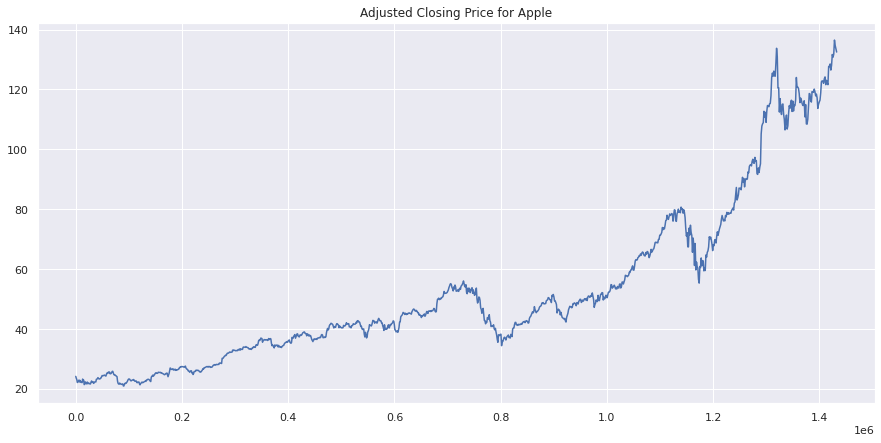

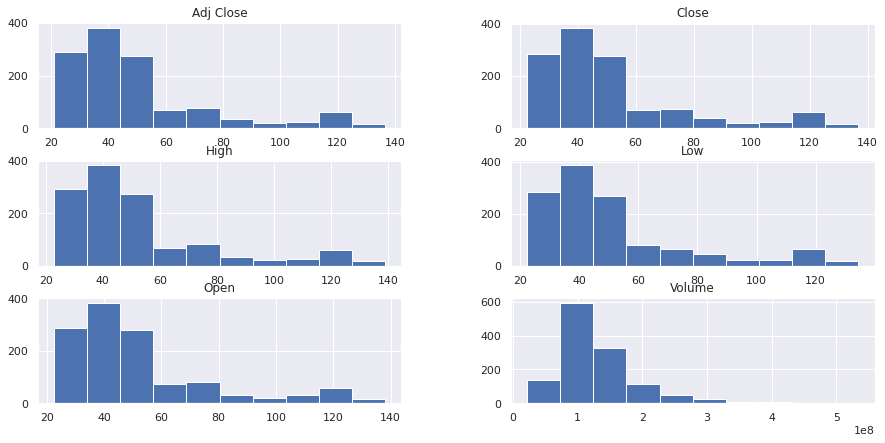

In [ ]:
apple_df = yahoo_df[yahoo_df["Ticker"] == "AAPL"]
apple_df["Adj Close"].plot(figsize=FIG_SIZE, title="Adjusted Closing Price for Apple", grid=True)
apple_df.hist(figsize=FIG_SIZE)
plt.show()

### Google

> Reference: https://www.google.com/

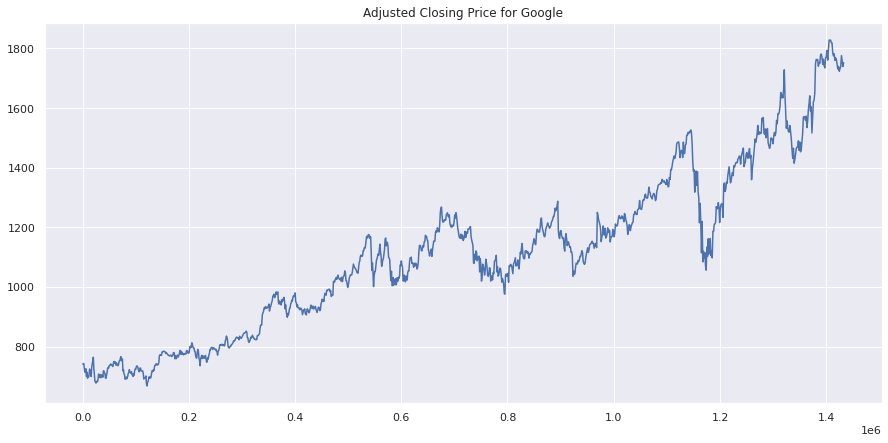

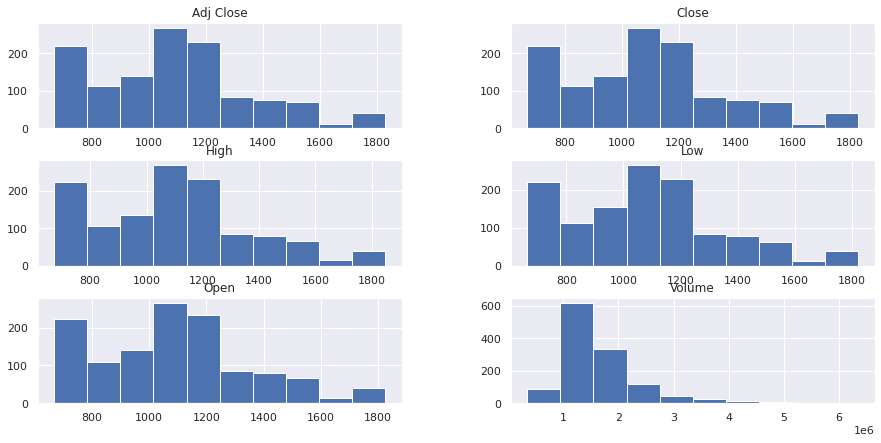

In [ ]:
google_df = yahoo_df[yahoo_df["Ticker"] == "GOOG"]
google_df["Adj Close"].plot(figsize=FIG_SIZE, title="Adjusted Closing Price for Google", grid=True)
google_df.hist(figsize=FIG_SIZE)
plt.show()

### Microsoft

> Reference: https://www.microsoft.com/

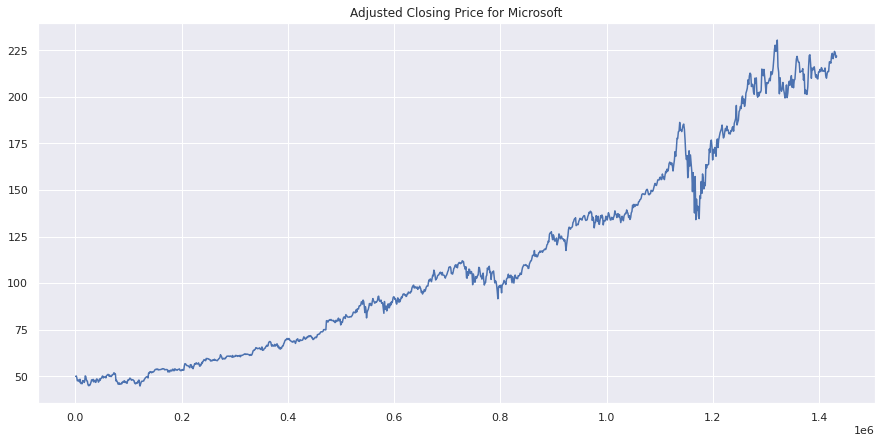

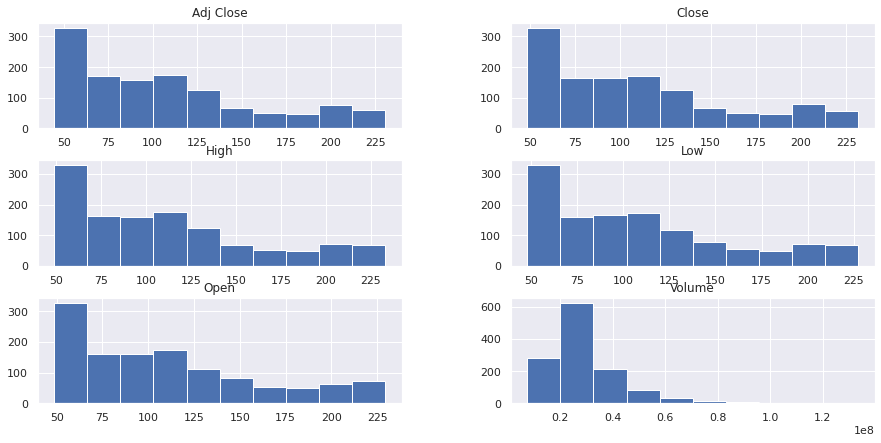

In [ ]:
microsoft_df = yahoo_df[yahoo_df["Ticker"] == "MSFT"]
microsoft_df["Adj Close"].plot(figsize=FIG_SIZE, title="Adjusted Closing Price for Microsoft", grid=True)
microsoft_df.hist(figsize=FIG_SIZE)
plt.show()

## Latent Variables (SB)

Bollinger Bands are a type of statistical chart characterizing the prices and volatility over time of a financial instrument or commodity.

> Reference: https://pylessons.com/RL-BTC-BOT-indicators

In [ ]:
yahoo_bb_df = add_bollinger_bands_indicators(yahoo_df.copy())
yahoo_bb_df.isna().sum()

Date          0
Ticker        0
Adj Close     0
Close         0
High          0
Low           0
Open          0
Volume        0
bb_bbm       19
bb_bbh       19
bb_bbl       19
dtype: int64

In [ ]:
yahoo_bb_df = yahoo_bb_df.dropna(axis=0, how="any")
yahoo_bb_df.isna().sum()

Date         0
Ticker       0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
bb_bbm       0
bb_bbh       0
bb_bbl       0
dtype: int64

In [ ]:
yahoo_bb_df

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,bb_bbm,bb_bbh,bb_bbl
19,2016-01-04,ADUS,22.889999,22.889999,23.170000,22.389999,23.020000,94400.0,50.249375,156.049283,-55.550533
20,2016-01-04,AEGN,19.070000,19.070000,19.360001,18.760000,18.969999,245400.0,49.157375,155.768052,-57.453302
21,2016-01-04,AEIS,27.044479,27.070000,27.850000,26.719999,27.530001,481100.0,49.403375,155.786105,-56.979355
22,2016-01-04,AEP,48.749325,58.330002,58.360001,57.529999,57.820000,4087800.0,51.003000,156.911357,-54.905357
23,2016-01-04,AGFS,6.280000,6.280000,6.350000,6.050000,6.210000,52000.0,49.306000,156.924937,-58.312937
...,...,...,...,...,...,...,...,...,...,...,...
1433742,2020-12-31,ZM,337.320007,337.320007,351.829987,336.100006,351.769989,6530400.0,87.288500,291.793869,-117.216870
1433743,2020-12-31,ZNGA,9.870000,9.870000,9.890000,9.660000,9.770000,12415400.0,81.705500,288.253304,-124.842304
1433744,2020-12-31,ZS,199.710007,199.710007,203.000000,198.619995,202.250000,1469600.0,86.049500,298.600152,-126.501152
1433745,2020-12-31,ZUMZ,36.779999,36.779999,37.110001,36.349998,36.400002,149500.0,87.106000,298.453093,-124.241093


## Feature Importance (SB)

Before we begin our efforts on clustering our data and feeding them into ML models, we first need to find out which features contribute to our predictive performance the most. In other words, we find the feature importance of our dataset to minimize the amount of data we need. We fit our data to a Linear Regression model to predict the target feature, ‘Last Sale’. From our model, we find the coefficients of the Linear Regression, which alone does not say much. To derive a conclusion regarding the feature importances using the Linear Regression coefficient, we multiply the coefficient with standard deviation of each of the features. Now, we can see which features are most important, and which features can be dropped further in our analysis.
For regression, feature importance ranks in the order of: `[Market Cap > Volume > Net Change > IPO Year > % Change]`

Additionally, though the Latent Variables that we created earlier, we can now see which features contribute the most to classification tasks. We use a RandomForest classifier and plot the gini score of the features. Our plot shows us that feature importance for classification ranks in the order of: `[Open > Close > Low > High > Adj Close > Volume]`

### Regression

In [ ]:
x_columns, y_column = ["Net Change", "% Change", "Market Cap", "IPO Year", "Volume"], "Last Sale"

nasdaq_features_df = nasdaq_df[x_columns + [y_column]]
nasdaq_features_df.isna().sum()

Net Change      0
% Change        0
Market Cap      2
IPO Year      635
Volume          0
Last Sale       0
dtype: int64

In [ ]:
nasdaq_features_df = nasdaq_features_df.dropna(axis=0, how="any")
nasdaq_features_df.isna().sum()

Net Change    0
% Change      0
Market Cap    0
IPO Year      0
Volume        0
Last Sale     0
dtype: int64

In [ ]:
nasdaq_features_x_df = nasdaq_features_df[x_columns]
nasdaq_features_y_df = nasdaq_features_df[y_column]

regressor = LinearRegression().fit(nasdaq_features_x_df, nasdaq_features_y_df)
predictions = regressor.predict(nasdaq_features_x_df)

feature_importance = pd.DataFrame(regressor.coef_, x_columns, ["coefficient"])
feature_importance.coefficient = feature_importance.coefficient.abs()

stddev = []
for i in nasdaq_features_x_df.columns:
    stddev.append(nasdaq_features_df[i].std())
    
feature_importance["stddev"] = np.array(stddev).reshape(-1, 1)
feature_importance["importance"] = feature_importance["coefficient"] * feature_importance["stddev"]
feature_importance

,coefficient,stddev,importance
Net Change,1.207095e+01,3.715946e+00,44.854994
% Change,5.089947e+02,4.555534e-02,23.187428
Market Cap,1.038813e-09,1.308926e+11,135.972954
IPO Year,1.671267e+00,1.130431e+01,18.892520
Volume,1.671715e-05,5.151875e+06,86.124650


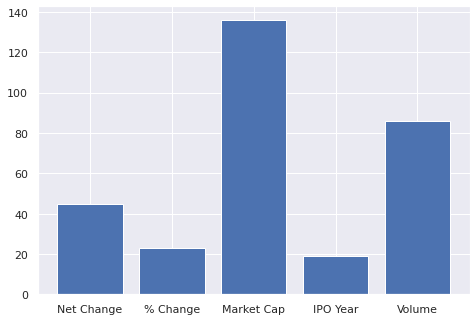

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(x_columns, feature_importance["importance"])
plt.show()

> Order of feature importance: `[Market Cap > Volume > Net Change > % Change > IPO Year]`

### Classification

In [ ]:
yahoo_bb_df.loc[yahoo_bb_df.bb_bbh > yahoo_bb_df.Close, "target"] = "BUY"
yahoo_bb_df.loc[(yahoo_bb_df.bb_bbl <= yahoo_bb_df.Close) & (yahoo_bb_df.bb_bbm > yahoo_bb_df.Close), "target"] = "HOLD"
yahoo_bb_df.loc[yahoo_bb_df.bb_bbh <= yahoo_bb_df.Close, "target"] = "SELL"
yahoo_bb_df["target"].value_counts()

HOLD    985082
BUY     364725
SELL     83921
Name: target, dtype: int64

#### Muller Loop Classification

Classifier = Nearest Neighbors, Score = 82.96, Training Time = 0.43
Classifier = Linear SVM, Score = 86.25, Training Time = 13.53
Classifier = RBF SVM, Score = 86.74, Training Time = 29.35
Classifier = Decision Tree, Score = 86.79, Training Time = 0.15
Classifier = Random Forest, Score = 86.95, Training Time = 0.28
Classifier = Neural Net, Score = 86.56, Training Time = 5.29
Classifier = AdaBoost, Score = 28.41, Training Time = 2.60
Classifier = Naive Bayes, Score = 86.31, Training Time = 0.01
Classifier = QDA, Score = 81.58, Training Time = 0.04
----------------------------------------------------------------------------------------------------
Best --> Classifier = Random Forest, Score = 86.95


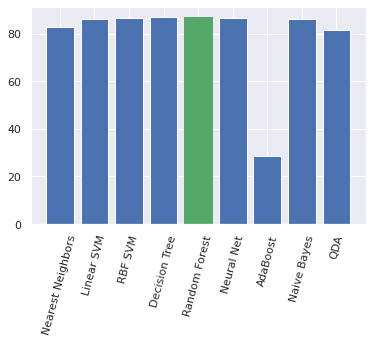

In [ ]:
yahoo_bb_sample_df = yahoo_bb_df.sample(SAMPLE)
yahoo_bb_x_df = yahoo_bb_sample_df[["Adj Close", "Close", "High", "Low", "Open", "Volume"]]
yahoo_bb_y_df = pd.factorize(yahoo_bb_sample_df["target"])[0].astype("int")
muller_loop_classifiers(yahoo_bb_x_df, yahoo_bb_y_df)

#### Gini Score

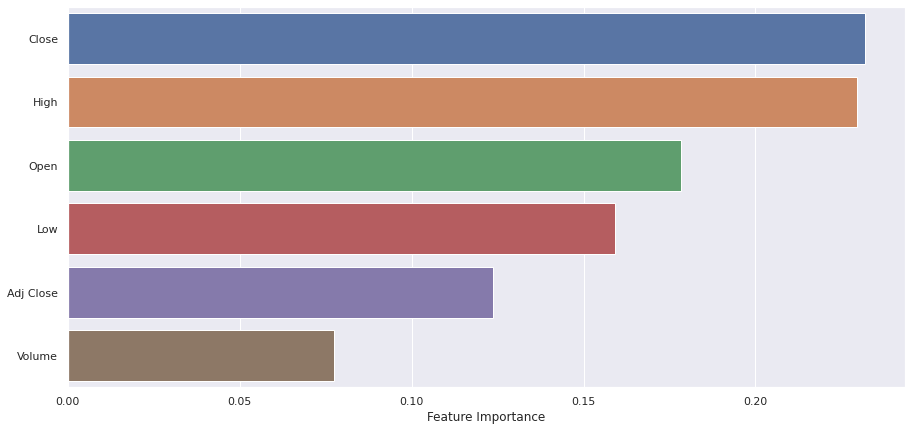

In [ ]:
gini_score(yahoo_bb_x_df, yahoo_bb_y_df)

## Principal Component Analysis Before Amalgamation (SB)

Next, we perform PCA on our initial NASDAQ dataset to prepare it for regression analysis using our Muller Loop. We see that our data 90% of our data is accounted for by 4 dimensions, and so we select 4 Principal Components for our PCA. We run the Muller Loop on our initial NASDAQ dataset after it is run through PCA and we see that it returns bad results.

With our highest model, the Random Forest, returning a score of 58.95, we see that we have a problem with our data. Perhaps it is not large enough and needs some extra data to strengthen our performance.

4 dimensions needed for 90% variance


,PC1,PC2,PC3,PC4
0,23.279357,12.139279,3.569879,4.341603
1,-0.378354,0.847945,-1.221649,-0.058357
2,0.602594,0.118312,1.208210,0.097721
3,-0.243100,0.580742,-0.318403,-0.154046
4,-0.493872,0.113173,1.020203,-0.049912
...,...,...,...,...
780,1.406803,-2.574579,1.050212,0.863773
781,0.646579,-0.264275,1.070779,-0.181783
782,1.637639,1.117181,0.869653,0.746821
783,0.035481,-0.296821,0.881527,-0.026550


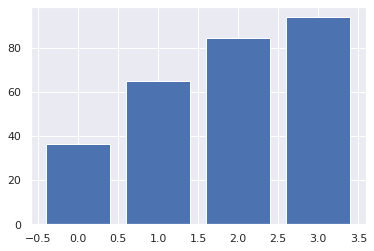

In [ ]:
nasdaq_features_pca_x_df = find_variance(nasdaq_features_x_df)
nasdaq_features_pca_x_df

### Muller Loop Regression

Very poor score before amalgamation. This is due to timeseries dataset. Results are inconsistent.

Regressor = KNearest Neighbors, Score = -37.34, MSE = 15444.86, MAE = 34.09, Training Time = 0.01
Regressor = Linear Regression, Score = 40.57, MSE = 6683.67, MAE = 50.84, Training Time = 0.00
Regressor = Random Forest, Score = 58.95, MSE = 4616.72, MAE = 25.23, Training Time = 0.37


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Regressor = MLPRegressor, Score = -34.08, MSE = 15077.45, MAE = 65.25, Training Time = 0.21
----------------------------------------------------------------------------------------------------
Best --> Regressor = Random Forest, Score = 58.95


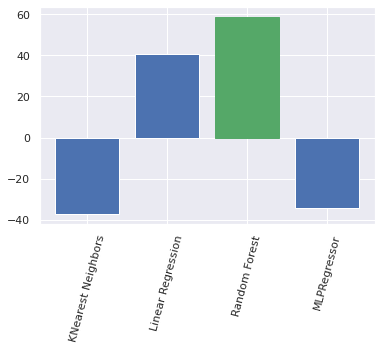

In [ ]:
run = True
while run:
    try:
        muller_loop_regression(nasdaq_features_pca_x_df, nasdaq_features_y_df)
        run = False
    except Exception:
        clear_output()

## Amalgamate (RK)

We merged Nasdaq data with Yahoo! Finance data on its natural key (ticker/symbol).

This dataset gives us a large amount of important information, so hopefully it will address our problems of having low predictive power. 
We join our initial dataset on this new yahoo dataset to combine into the nasdaq_yahoo dataset, which has 1378414 rows and 16 columns.
Some of these columns are not useful for further analysis, so we drop them.
Now, we turn to PCA again as we prepare to feed our model into the regression muller loop. Similar to the base dataset, we see that 4 dimensions account for 90% of the variance in our data, so we select 4 Principal Components.
Now we are ready to run the Muller Loop in hopes that the additional data will improve our predictive power.

In [ ]:
yahoo_nasdaq_df = yahoo_df.merge(nasdaq_df, left_on="Ticker", right_on="Symbol")
yahoo_nasdaq_df.drop(columns=["Symbol"], inplace=True)
yahoo_nasdaq_df

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume_x,Name,Last Sale,Net Change,% Change,Market Cap,IPO Year,Volume_y,Industry
0,2016-01-04,AAL,39.095455,40.910000,41.349998,40.299999,41.290001,12037200.0,American Airlines Group Inc. Common Stock,23.8300,-1.1400,-0.04565,1.524347e+10,NaN,42536132,Air Freight/Delivery Services
1,2016-01-05,AAL,38.722763,40.520000,41.490002,39.950001,41.180000,10514200.0,American Airlines Group Inc. Common Stock,23.8300,-1.1400,-0.04565,1.524347e+10,NaN,42536132,Air Freight/Delivery Services
2,2016-01-06,AAL,39.401257,41.230000,41.700001,40.000000,40.049999,12393800.0,American Airlines Group Inc. Common Stock,23.8300,-1.1400,-0.04565,1.524347e+10,NaN,42536132,Air Freight/Delivery Services
3,2016-01-07,AAL,38.655853,40.450001,41.520000,39.680000,40.970001,11312900.0,American Airlines Group Inc. Common Stock,23.8300,-1.1400,-0.04565,1.524347e+10,NaN,42536132,Air Freight/Delivery Services
4,2016-01-08,AAL,38.579407,40.369999,41.360001,40.259998,40.939999,8853100.0,American Airlines Group Inc. Common Stock,23.8300,-1.1400,-0.04565,1.524347e+10,NaN,42536132,Air Freight/Delivery Services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433742,2020-12-24,LBRDP,28.359938,28.799999,28.799999,28.790001,28.790001,1800.0,Liberty Broadband Corporation Series A Cumulat...,27.1629,0.4029,0.01506,0.000000e+00,NaN,5306,Telecommunications Equipment
1433743,2020-12-28,LBRDP,28.071415,28.507000,28.799999,28.309999,28.799999,5600.0,Liberty Broadband Corporation Series A Cumulat...,27.1629,0.4029,0.01506,0.000000e+00,NaN,5306,Telecommunications Equipment
1433744,2020-12-29,LBRDP,28.227001,28.665001,28.799999,28.620001,28.620001,1300.0,Liberty Broadband Corporation Series A Cumulat...,27.1629,0.4029,0.01506,0.000000e+00,NaN,5306,Telecommunications Equipment
1433745,2020-12-30,LBRDP,28.450001,28.450001,28.799999,28.450001,28.799999,2900.0,Liberty Broadband Corporation Series A Cumulat...,27.1629,0.4029,0.01506,0.000000e+00,NaN,5306,Telecommunications Equipment


## Principal Component Analysis After Amalgamation (SB)

In [ ]:
x_columns.remove("Volume")
x_columns.append("Volume_y")

xx_columns = ["Adj Close", "Close", "High", "Low", "Open", "Volume_x"] + x_columns

yahoo_nasdaq_features_df = yahoo_nasdaq_df[xx_columns + [y_column]].sample(SAMPLE)
yahoo_nasdaq_features_df.isna().sum()

Adj Close         0
Close             0
High              0
Low               0
Open              0
Volume_x          0
Net Change        0
% Change          0
Market Cap        0
IPO Year      24074
Volume_y          0
Last Sale         0
dtype: int64

In [ ]:
yahoo_nasdaq_features_df = yahoo_nasdaq_features_df.dropna(axis=0, how="any")
yahoo_nasdaq_features_df.isna().sum()

Adj Close     0
Close         0
High          0
Low           0
Open          0
Volume_x      0
Net Change    0
% Change      0
Market Cap    0
IPO Year      0
Volume_y      0
Last Sale     0
dtype: int64

4 dimensions needed for 90% variance


,PC1,PC2,PC3,PC4
0,-0.908909,-0.096572,-0.194605,0.751023
1,1.017742,-0.576982,-0.165100,1.160184
2,-0.812777,-0.139436,-0.401593,-0.010345
3,0.385344,-0.210098,0.025148,-0.005637
4,-0.799857,-0.013661,-0.745763,0.935705
...,...,...,...,...
25921,-0.440636,0.035410,-0.853305,0.126600
25922,-0.612687,0.041817,-1.901704,0.726050
25923,-0.706342,-0.041275,-0.547960,-1.129231
25924,0.730053,1.967429,-0.734445,-1.060897


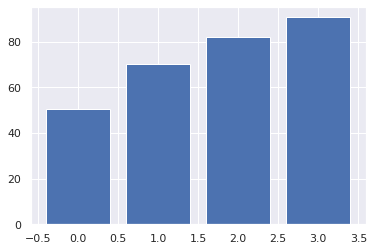

In [ ]:
yahoo_nasdaq_features_x_df = yahoo_nasdaq_features_df[xx_columns]
yahoo_nasdaq_features_y_df = yahoo_nasdaq_features_df[y_column]

yahoo_nasdaq_features_pca_x_df = find_variance(yahoo_nasdaq_features_x_df)
yahoo_nasdaq_features_pca_x_df

### Muller Loop Regression

Significantly better scores after amalgamation.

Regressor = KNearest Neighbors, Score = 99.22, MSE = 258.35, MAE = 1.62, Training Time = 0.06
Regressor = Linear Regression, Score = 77.45, MSE = 7442.72, MAE = 34.06, Training Time = 0.01
Regressor = Random Forest, Score = 98.71, MSE = 424.29, MAE = 6.75, Training Time = 10.61
Regressor = MLPRegressor, Score = 81.42, MSE = 6133.21, MAE = 33.31, Training Time = 4.87
----------------------------------------------------------------------------------------------------
Best --> Regressor = KNearest Neighbors, Score = 99.22


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


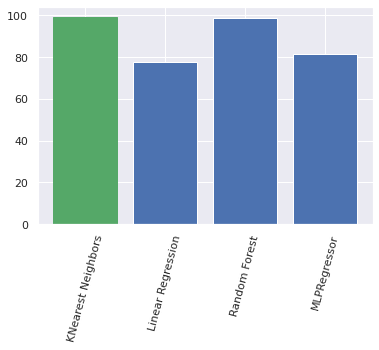

In [ ]:
muller_loop_regression(yahoo_nasdaq_features_pca_x_df, yahoo_nasdaq_features_y_df)

## Fractal Clustering (PJ)

Goal is to identify stocks with strong average yearly returns and low average yearly variance. 

We also include a few semi-high risk, high return stocks to emulate a well diversed portfolio.

> Reference: https://medium.com/uptick-blog/stock-picks-using-k-means-clustering-4330c6c4e8de

In [ ]:
yahoo_5y_df = (
    yahoo_df.pipe(
        lambda x: x.assign(Year=pd.to_datetime(x.Date).dt.year)
    )[
        ["Ticker", "Date", "Year", "Open", "Close"]
    ]
)
yahoo_5y_df

,Ticker,Date,Year,Open,Close
0,AAL,2016-01-04,2016,41.290001,40.910000
1,AAON,2016-01-04,2016,22.820000,22.150000
2,AAPL,2016-01-04,2016,25.652500,26.337500
3,AAWW,2016-01-04,2016,40.500000,40.220001
4,ABCB,2016-01-04,2016,33.430000,32.549999
...,...,...,...,...,...
1433742,ZM,2020-12-31,2020,351.769989,337.320007
1433743,ZNGA,2020-12-31,2020,9.770000,9.870000
1433744,ZS,2020-12-31,2020,202.250000,199.710007
1433745,ZUMZ,2020-12-31,2020,36.400002,36.779999


In [ ]:
yahoo_5y_first_date_df = pd.DataFrame({"Date": [yahoo_5y_df.query("Year == '{}'".format(2016 + i)).Date.min() for i in range(5)]})

yahoo_5y_agg_first_date_df = (
    yahoo_5y_df.merge(
        yahoo_5y_first_date_df, on="Date", how="inner"
    ).pipe(
        lambda x: x.assign(Year=pd.to_datetime(x.Date).dt.year)
    ).rename(
        columns={"Open": "open_first_day"}
    ).reset_index(
        drop=True
    )[
        ["Ticker", "Year", "open_first_day"]
    ].pivot_table(
        values="open_first_day", columns="Year", index="Ticker", aggfunc="sum"
    ).rename_axis(
        None, axis=1
    ).reset_index(
    ).melt(
        id_vars="Ticker", value_vars=[2016, 2017, 2018, 2019, 2020]
    ).rename(
        columns={"variable": "Year", "value": "open_first_day"}
    )
)
yahoo_5y_agg_first_date_df

,Ticker,Year,open_first_day
0,AAL,2016,41.290001
1,AAON,2016,22.820000
2,AAPL,2016,25.652500
3,AAWW,2016,40.500000
4,ABCB,2016,33.430000
...,...,...,...
6250,ZM,2020,68.800003
6251,ZNGA,2020,6.190000
6252,ZS,2020,46.869999
6253,ZUMZ,2020,34.840000


In [ ]:
yahoo_5y_last_date_df = pd.DataFrame({"Date": [yahoo_5y_df.query("Year == '{}'".format(2016 + i)).Date.max() for i in range(5)]})

yahoo_5y_agg_last_date_df = (
    yahoo_5y_df.merge(
        yahoo_5y_last_date_df, on="Date", how="inner"
    ).pipe(
        lambda x: x.assign(Year=pd.to_datetime(x.Date).dt.year)
    ).rename(
        columns={"Close": "close_last_day"}
    ).reset_index(
        drop=True
    )[
        ["Ticker", "Year", "close_last_day"]
    ].pivot_table(
        values="close_last_day", columns="Year", index="Ticker", aggfunc="sum"
    ).rename_axis(
        None, axis=1
    ).reset_index(
    ).melt(
        id_vars="Ticker", value_vars=[2016, 2017, 2018, 2019, 2020]
    ).rename(
        columns={"variable": "Year", "value": "close_last_day"}
    )
)
yahoo_5y_agg_last_date_df

,Ticker,Year,close_last_day
0,AAL,2016,46.689999
1,AAON,2016,33.049999
2,AAPL,2016,28.955000
3,AAWW,2016,52.150002
4,ABCB,2016,43.599998
...,...,...,...
6855,ZM,2020,337.320007
6856,ZNGA,2020,9.870000
6857,ZS,2020,199.710007
6858,ZUMZ,2020,36.779999


In [ ]:
yahoo_5y_agg_gains_df = (
    yahoo_5y_agg_first_date_df.merge(
        yahoo_5y_agg_last_date_df, on=["Ticker", "Year"], how="inner"
    ).pipe(
        lambda x: x.assign(gains_dollar=x.close_last_day - x.open_first_day)
    ).pipe(
        lambda x: x.assign(gains_pctg=x.gains_dollar / x.open_first_day)
    ).groupby(
        "Ticker"
    ).agg(
        {"gains_pctg": "mean"}
    ).reset_index(
    ).rename(
        columns={"gains_pctg": "avg_yearly_returns"}
    )
)

yahoo_5y_agg_var_df = (
    yahoo_5y_agg_first_date_df.merge(
        yahoo_5y_agg_last_date_df, on=["Ticker", "Year"], how="inner"
    ).pipe(
        lambda x: x.assign(gains_dollar=x.close_last_day - x.open_first_day)
    ).pipe(
        lambda x: x.assign(gains_pctg=x.gains_dollar / x.open_first_day)
    )[
        ["Ticker", "gains_pctg"]
    ].groupby(
        "Ticker"
    ).agg(
        np.var
    ).reset_index(
    ).rename(
        columns={"gains_pctg": "yearly_variance"}
    )
)

yahoo_5y_agg_df3 = (
    yahoo_5y_agg_gains_df.merge(
        yahoo_5y_agg_var_df, on="Ticker", how="inner"
    )
)

yahoo_5y_agg_df3 = yahoo_5y_agg_df3.dropna()
yahoo_5y_agg_df3

,Ticker,avg_yearly_returns,yearly_variance
0,AAL,-0.139869,0.073568
1,AAON,0.252144,0.048270
2,AAPL,0.440933,0.172992
3,AAWW,0.151201,0.272042
4,ABCB,0.059228,0.086638
...,...,...,...
1244,ZIOP,0.000370,0.807675
1245,ZIXI,0.123846,0.034164
1247,ZNGA,0.334629,0.102057
1248,ZS,1.736094,4.650280


### Round 1

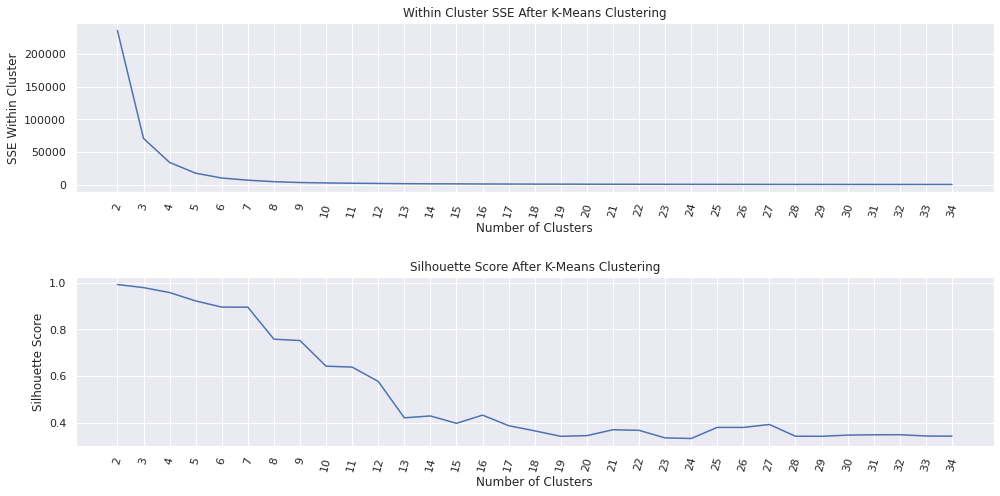

In [ ]:
plot_cluster(yahoo_5y_agg_df3, 35)

In [ ]:
round_1_df = apply_cluster(yahoo_5y_agg_df3, clusters=13)
round_1_cluster_df = (
    round_1_df.groupby(
        "cluster"
    ).agg(
        {"avg_yearly_returns": "mean", "yearly_variance": "mean", "Ticker": "count"}
    ).sort_values(
        "avg_yearly_returns"
    ).reset_index()
)
round_1_cluster_df

Cluster Performance
-------------------------
Silhouette Score: 0.42
SSE Within Cluster: 1480.0


,cluster,avg_yearly_returns,yearly_variance,Ticker
0,0,0.006833,0.079172,676
1,10,0.303942,0.163206,327
2,7,0.368986,0.698305,102
3,12,0.529820,1.729590,27
4,5,1.058137,4.098831,16
5,4,1.334481,8.505798,5
6,11,1.463581,12.488844,2
7,9,2.027500,21.611188,1
8,6,2.392371,36.558345,1
9,8,2.791115,16.441969,1


> Selecting less than 13 clusters resulted in +95% of stocks clumped to in a single cluster, which is not useful. Therefore, we will select clusters `[10, 7, 12, 5]` for the next round of clustering.

### Round 2

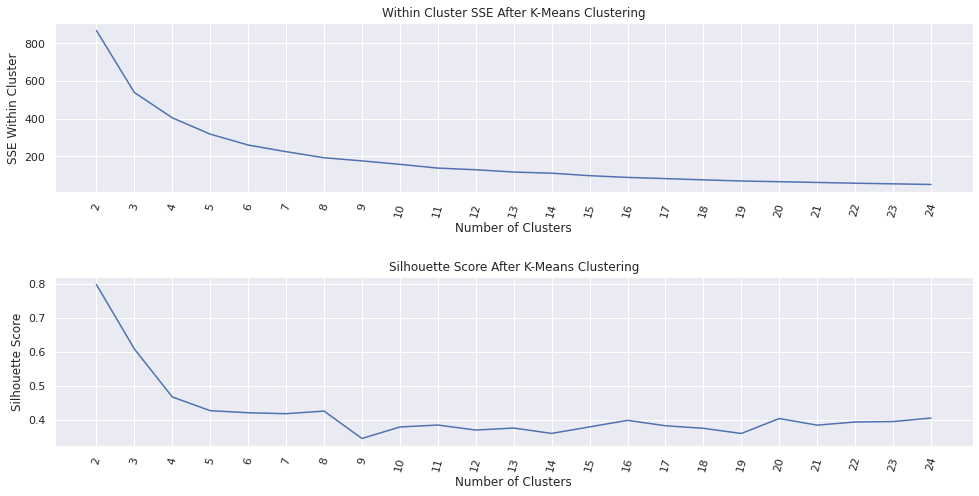

In [ ]:
yahoo_5y_agg_df3_sub = yahoo_5y_agg_df3.query("cluster in [10, 7, 12, 5]").reset_index(drop=True)
plot_cluster(yahoo_5y_agg_df3_sub, 25)

In [ ]:
round_2_df = apply_cluster(yahoo_5y_agg_df3_sub, clusters=4)
round_2_cluster_df = (
    round_2_df.groupby(
        "cluster"
    ).agg(
        {"avg_yearly_returns": "mean", "yearly_variance": "mean", "Ticker": "count"}
    ).sort_values(
        "avg_yearly_returns"
    ).reset_index()
)
round_2_cluster_df

Cluster Performance
-------------------------
Silhouette Score: 0.47
SSE Within Cluster: 405.0


,cluster,avg_yearly_returns,yearly_variance,Ticker
0,0,0.232102,0.230499,316
1,3,0.475250,1.504666,41
2,2,0.590922,0.371366,99
3,1,1.058137,4.098831,16


#### Sharpe Ratio

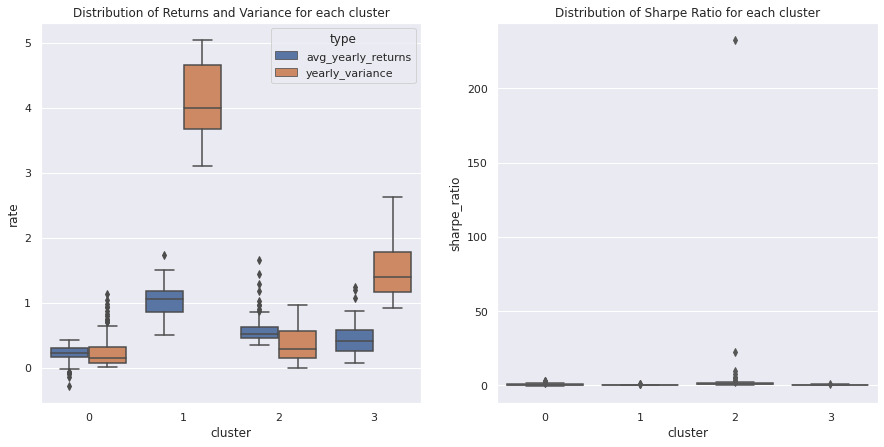

In [ ]:
round_2_w_sharpe_ratio_df = sharpe_ratio(round_2_df)
cluster_perf(round_2_w_sharpe_ratio_df)

> Selecting 4 clusters, we noticed a change in the trend, that is, a cluster with higher average yearly returns had lower yearly variance than a cluster with lower average yearly return. Therefore, we will select cluster `[2]` for the next round of clustering and cluster `[1]` for some added semi-high risk, high return to the portfolio. 

### Round 3

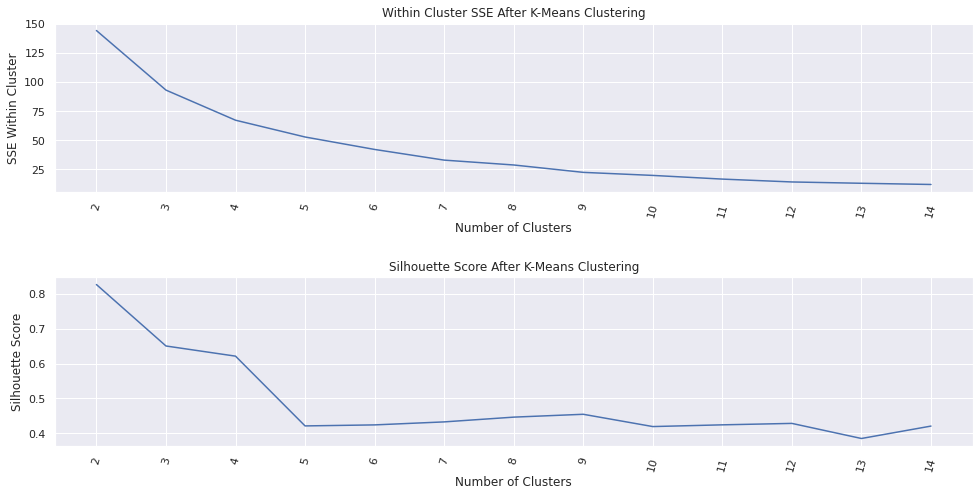

In [ ]:
yahoo_5y_agg_df3_sub_sub = round_2_df.query("cluster in [2, 1]").reset_index(drop=True)
plot_cluster(yahoo_5y_agg_df3_sub_sub, 15)

In [ ]:
round_3_df = apply_cluster(yahoo_5y_agg_df3_sub_sub, clusters=3)
round_3_cluster_df = (
    round_3_df.groupby(
        "cluster"
    ).agg(
        {"avg_yearly_returns": "mean", "yearly_variance": "mean", "Ticker": "count"}
    ).sort_values(
        "avg_yearly_returns"
    ).reset_index()
)
round_3_cluster_df

Cluster Performance
-------------------------
Silhouette Score: 0.65
SSE Within Cluster: 93.0


,cluster,avg_yearly_returns,yearly_variance,Ticker
0,0,0.531672,0.353661,89
1,1,1.058137,4.098831,16
2,2,1.118250,0.528945,10


#### Sharpe Ratio

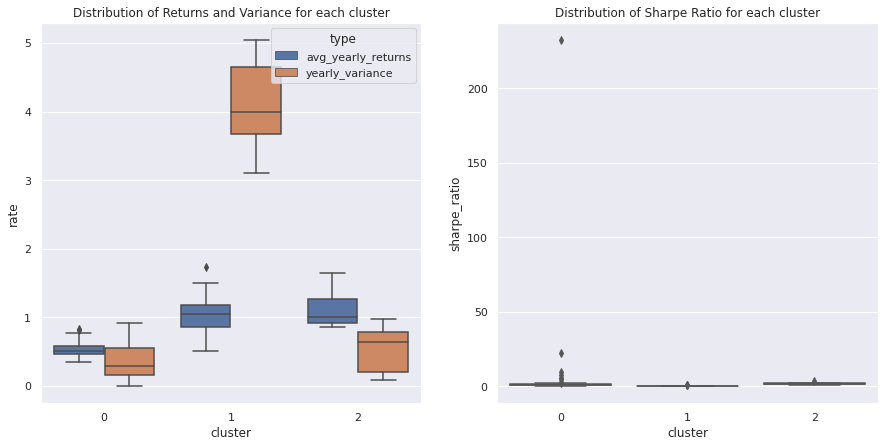

In [ ]:
round_3_w_sharpe_ratio_df = sharpe_ratio(round_3_df)
cluster_perf(round_3_w_sharpe_ratio_df)

> Selecting 3 clusters, we noticed a change in the trend, that is, a cluster with higher average yearly returns had lower yearly variance than a cluster with lower average yearly return. Therefore, we deem cluster `[2]` as the golden cluster.

### Golden Cluster

> We visualized market trends on golden cluster stocks.

[*********************100%***********************]  10 of 10 completed


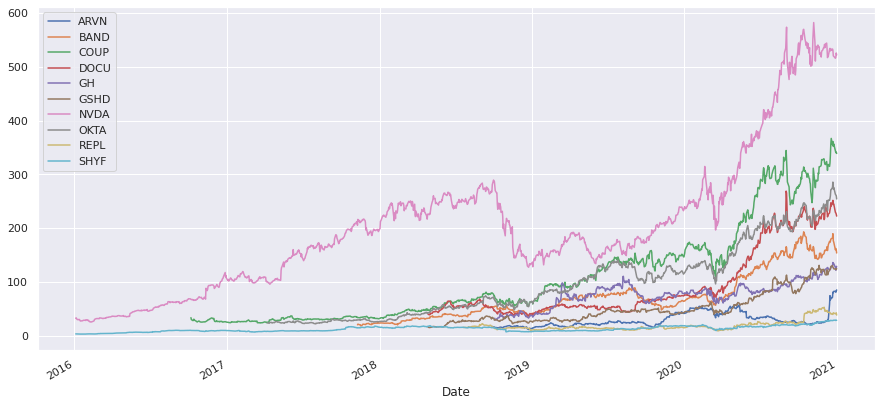

(10, 'ARVN BAND COUP DOCU GH GSHD NVDA OKTA REPL SHYF')

In [ ]:
golden_cluster = round_3_df.query("cluster == 2").reset_index(drop=True)
golden_tickers = golden_cluster.Ticker.tolist()
yf.download(golden_tickers, start="2016-01-01", end="2021-01-01")["Close"].plot(figsize=FIG_SIZE)
plt.show()
len(golden_tickers), " ".join(golden_tickers)

Using the golden cluster of stocks, show the market trends, Using this market trends highlight the low, medium, and high value stocks.


In [ ]:
# Based on the final round analysis of fractal clustering:
high_value_stock = round_3_df.query("cluster == 2").Ticker.unique()
medium_value_stock = round_3_df.query("cluster == 0").Ticker.unique()
low_value_stock = round_3_df.query("cluster == 1").Ticker.unique()

print('High value stocks: ', high_value_stock, sep=',')
print('\nMedium value stocks: ', medium_value_stock, sep=',')
print('\nLow value stocks: ', low_value_stock, sep=',')

High value stocks: ,['ARVN' 'BAND' 'COUP' 'DOCU' 'GH' 'GSHD' 'NVDA' 'OKTA' 'REPL' 'SHYF']

Medium value stocks: ,['AAPL' 'ABMD' 'ALGN' 'ALLK' 'ALRM' 'AMAT' 'AMED' 'APLS' 'ARNA' 'ATLC'
 'AXNX' 'AXTI' 'BL' 'BLDR' 'BOOM' 'BPMC' 'BRKS' 'CDNS' 'CDXS' 'CENX'
 'CGNX' 'COHR' 'CPRT' 'CROX' 'CRUS' 'CVGI' 'CWST' 'CZR' 'DXCM' 'EDIT'
 'EHTH' 'ENTG' 'EXEL' 'FOXF' 'FTDR' 'GLUU' 'HALO' 'IAC' 'ICHR' 'IDXX'
 'IIVI' 'INSG' 'IPHI' 'KNSL' 'KTOS' 'KURA' 'LGIH' 'LOB' 'LOGI' 'LPSN'
 'LQDT' 'LRCX' 'LSCC' 'MASI' 'MGI' 'MPWR' 'MTCH' 'MU' 'NOVT' 'NTRA' 'PCTY'
 'PODD' 'PRDO' 'PYPL' 'QDEL' 'QNST' 'RCM' 'REGI' 'RGEN' 'ROAD' 'SAIA'
 'SFIX' 'SNDX' 'SNPS' 'SONO' 'SRPT' 'SVMK' 'TBIO' 'TENB' 'TER' 'TTWO'
 'UCTT' 'USAT' 'VCTR' 'VICR' 'VRNS' 'YMAB' 'Z' 'ZG']

Low value stocks: ,['ARWR' 'CBAY' 'DNLI' 'EVLO' 'MDGL' 'MRSN' 'NKTR' 'PACB' 'PRTS' 'ROKU'
 'RUN' 'SGMO' 'SPWR' 'SRRK' 'UPWK' 'ZS']


In [ ]:
# To find out the most traded stocks for the year 2020 from golden cluster
# which investors may be interested in:
trade_vol = {}
most_traded_stock_on_a_day = {}
yahoo_2020_df = yahoo_df[yahoo_df['Date'] >= '2020-01-01']

for tick in golden_tickers:
    for _, row in yahoo_2020_df[yahoo_2020_df['Ticker'] == tick].iterrows():
        day = row["Date"]
        vol = row["Volume"]
        if day not in trade_vol:
            trade_vol[day] = []
        trade_vol[day].append((vol, tick))

for day in trade_vol:
    trade_vol[day].sort()
    most_traded_stock_on_a_day[day] = trade_vol[day][-1]

most_traded_stock_on_a_day

{'2020-01-02': (5938400.0, 'NVDA'),
 '2020-01-03': (5134600.0, 'NVDA'),
 '2020-01-06': (6565900.0, 'NVDA'),
 '2020-01-07': (7871400.0, 'NVDA'),
 '2020-01-08': (6927700.0, 'NVDA'),
 '2020-01-09': (6377800.0, 'NVDA'),
 '2020-01-10': (7907400.0, 'NVDA'),
 '2020-01-13': (7996000.0, 'NVDA'),
 '2020-01-14': (8977200.0, 'NVDA'),
 '2020-01-15': (6577600.0, 'NVDA'),
 '2020-01-16': (7104800.0, 'NVDA'),
 '2020-01-17': (6344800.0, 'NVDA'),
 '2020-01-21': (5447900.0, 'NVDA'),
 '2020-01-22': (5981000.0, 'NVDA'),
 '2020-01-23': (6112900.0, 'NVDA'),
 '2020-01-24': (9337800.0, 'NVDA'),
 '2020-01-27': (11763400.0, 'NVDA'),
 '2020-01-28': (7774400.0, 'NVDA'),
 '2020-01-29': (6471200.0, 'NVDA'),
 '2020-01-30': (7262600.0, 'NVDA'),
 '2020-01-31': (9260500.0, 'NVDA'),
 '2020-02-03': (6398200.0, 'NVDA'),
 '2020-02-04': (6788600.0, 'NVDA'),
 '2020-02-05': (5205500.0, 'NVDA'),
 '2020-02-06': (5457100.0, 'NVDA'),
 '2020-02-07': (4743800.0, 'NVDA'),
 '2020-02-10': (13240200.0, 'NVDA'),
 '2020-02-11': (15963900.0

#### Predict the value of an investments in the golden cluster.

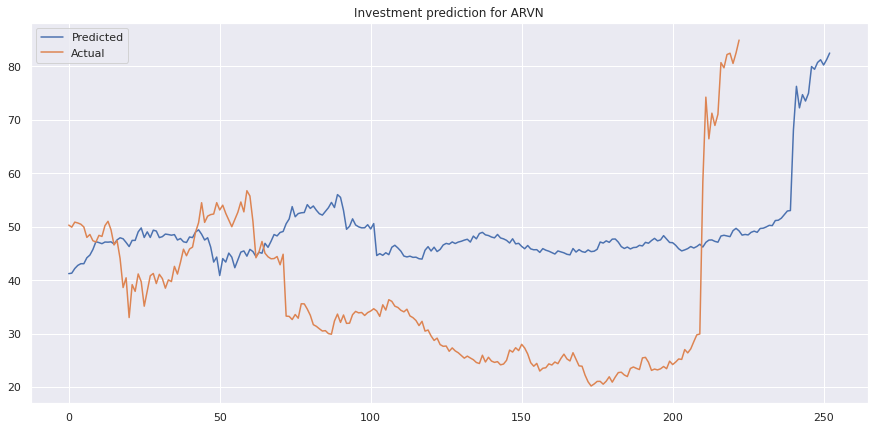

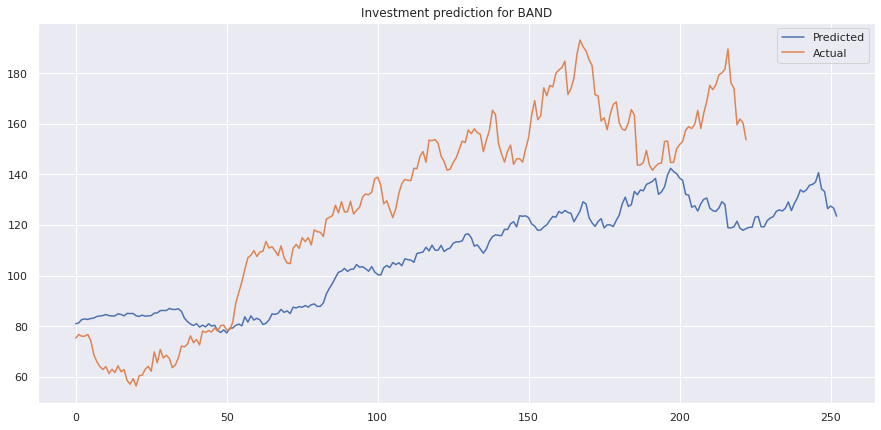

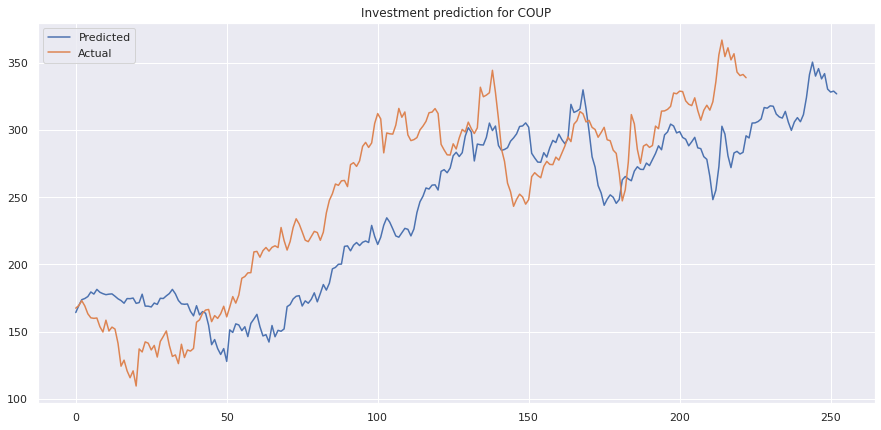

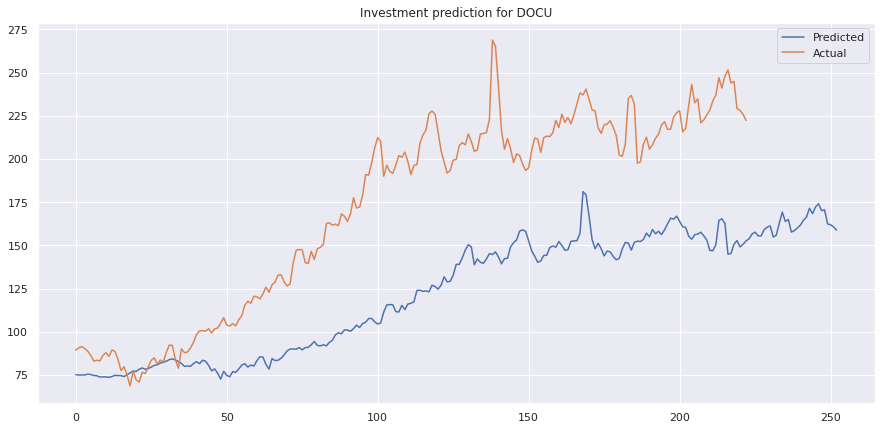

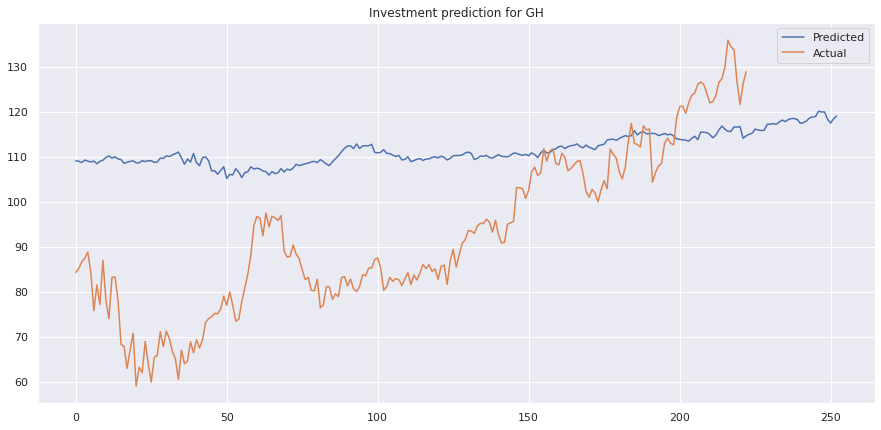

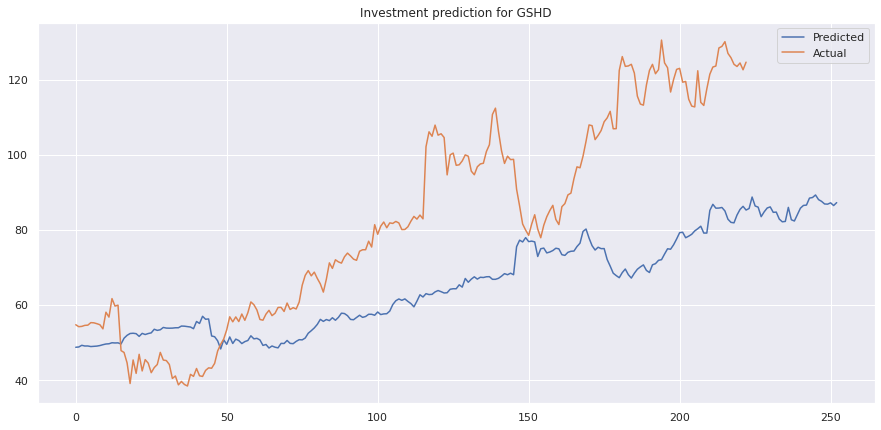

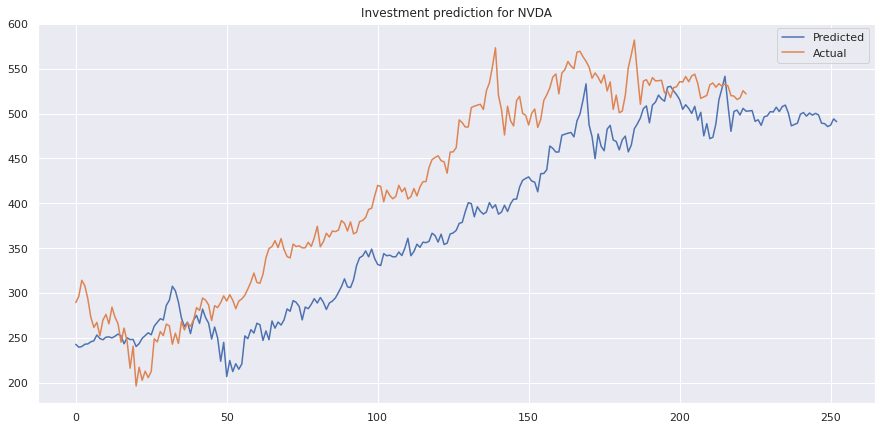

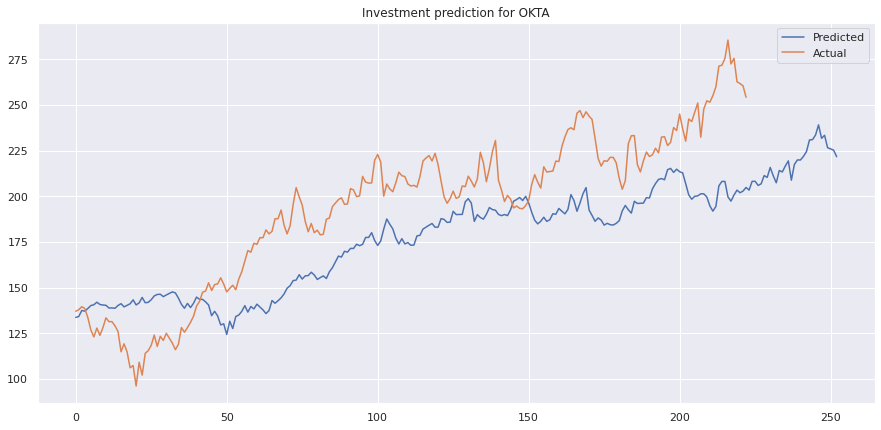

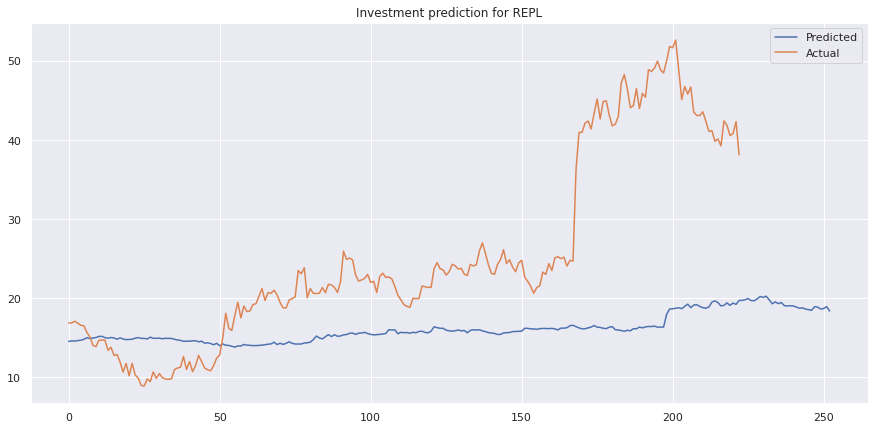

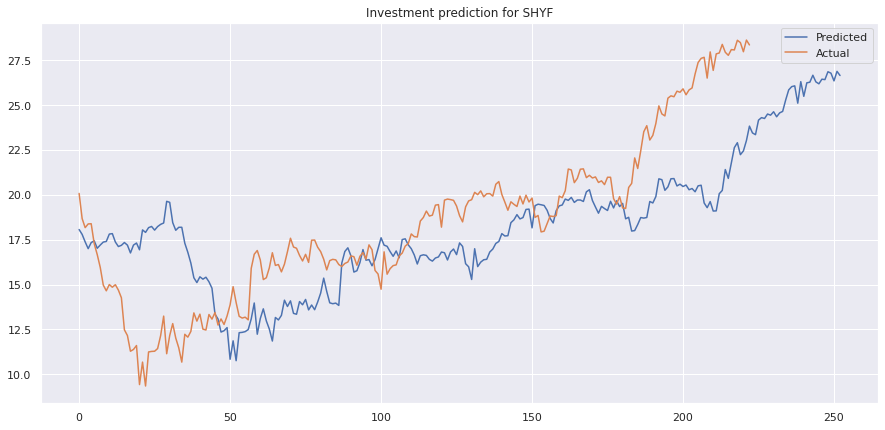

In [ ]:
for golden_ticker in golden_tickers:
    predict_investment(golden_ticker)

## Subject: NVIDIA (SB, PJ, RK)

> Reference: https://www.nvidia.com/

### 1. How close to earnings did stock value change?

In [ ]:
golden_financial_ratios_df = get_financial_ratios(golden_tickers)
golden_financial_ratios_df

,P/B,P/E,Forward P/E,PEG,Debt/Eq,EPS (ttm),Dividend %,ROE,ROI,EPS Q/Q,Insider Own
GSHD,242.60,242.60,242.60,242.60,242.60,242.60,242.60,242.60,242.60,242.60,242.60
NVDA,75.92,75.92,75.92,75.92,75.92,75.92,75.92,75.92,75.92,75.92,75.92
SHYF,34.30,34.30,34.30,34.30,34.30,34.30,34.30,34.30,34.30,34.30,34.30


### 2. Is this a stock to hold long term or a shorter term stock investment? Will the value go steadily higher if you hold on and ride the ups and down or is it a stock that constantly goes up and down and you should buy on the lows and sell on the highs rather than hold long term?

We predict that the best strategy for NVIDIA stock would be to hold on to it as a long term investment. It will steadily get higher and keeping it as a long term stock would be a safe bet.


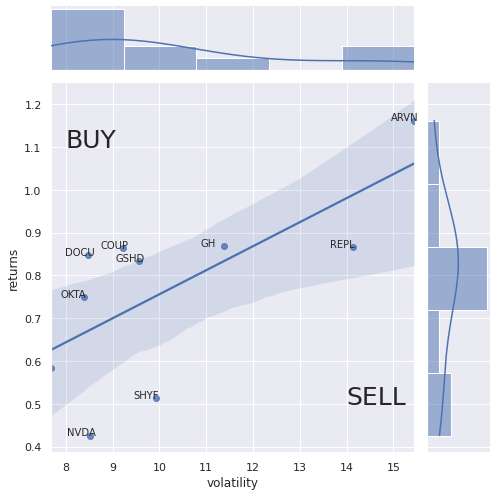

In [ ]:
golden_tickers_df = [yahoo_df[yahoo_df["Ticker"] == golden_ticker][['Date', 'Close']] for golden_ticker in golden_tickers]

golden_tickers_reduced_dfs = reduce(lambda left, right: pd.merge(left, right, on="Date"), golden_tickers_df).iloc[:, 1:].pct_change()

golden_tickers_combined_dfs = pd.DataFrame({"returns": golden_tickers_reduced_dfs.mean() * 252, "volatility": golden_tickers_reduced_dfs.std() * 252})

fig = sns.jointplot("volatility", "returns", data=golden_tickers_combined_dfs, kind="reg", height=7)
ax = fig.ax_joint

for i in range(golden_tickers_combined_dfs.shape[0]):
    ax.annotate(golden_tickers[i], (golden_tickers_combined_dfs.iloc[i, 1] - 0.5, golden_tickers_combined_dfs.iloc[i, 0]))

ax.text(8, 1.1, "BUY", fontsize=25)
ax.text(14, 0.5, "SELL", fontsize=25)
plt.show()

### 3. Which other companies does this company work with?

Coupa Software, Amazon

[*********************100%***********************]  3 of 3 completed


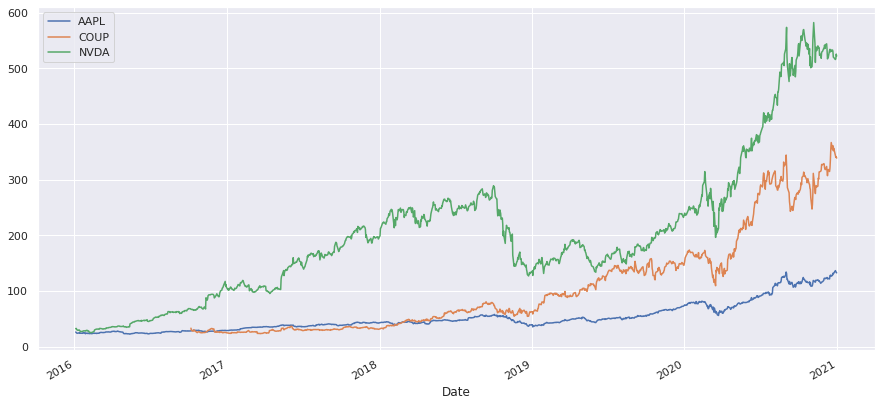

In [ ]:
companies = ['COUP', 'AAPL', "NVDA"]
yf.download(companies, start="2016-01-01", end="2021-01-01")["Close"].plot(figsize=FIG_SIZE)
plt.show()

### 4. Which are the highest dividend yield stocks in the golden cluster?

Out of the 10 stocks in the gold cluster, 3 stocks have the highest dividend yield.

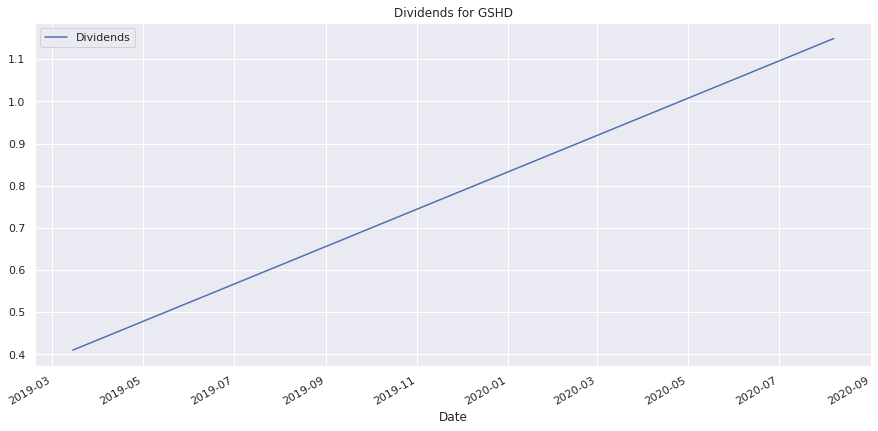

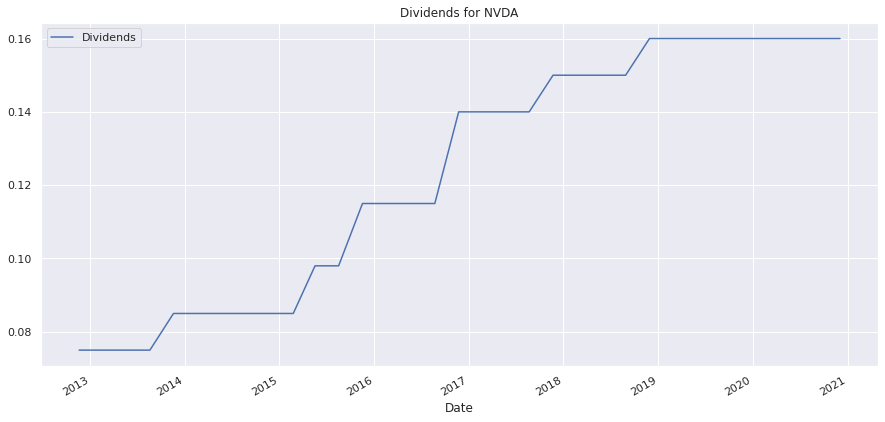

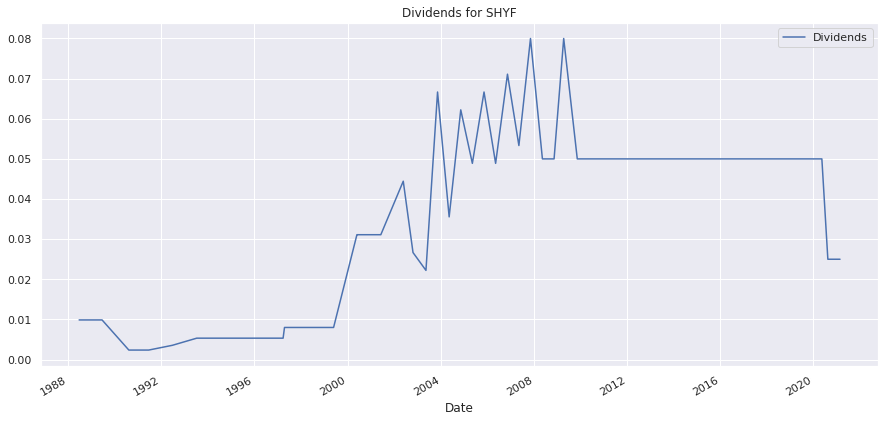

In [ ]:
for golden_ticker in golden_tickers:
    golden_dividends = yf.Ticker(golden_ticker).dividends
    if len(golden_dividends) > 0:
        golden_dividends.plot(figsize=FIG_SIZE)
        plt.title(f"Dividends for {golden_ticker}")
        plt.legend()
        plt.show()

### 5. Pick a stock from the golden cluster. If you buy it today how much will the price change (profit or loss, increase or decrease) after 2 years of holding on to it?

Our analysis throughout the study shows us that NVIDIA stock will continuously increase and it is a safer bet to hold on to the stock for the long run rather than trying to buy on the lows and sell on the highs. Though it is possible and may be profitable to also buy on the lows and sell on the highs, as you can expect to see big jumps, so it is a more risky and requires more effort but it seems safe to bet on NVIDIA 2 year from now.